Importing Libraries

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from prophet.diagnostics import cross_validation

Data Cleaning

In [2]:
df = pd.read_csv('pge_1.csv')
df = df.drop([0, 1, 2,3])

In [3]:
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

In [4]:
df.reset_index(drop=True, inplace=True)
df.drop(['TYPE','START TIME','END TIME','UNITS','NOTES'],axis=1,inplace=True)
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

<ipython-input-4-991e3eef82d3>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


4,DATE,USAGE,COST
0,2022-04-24,0.02,$0.01
1,2022-04-24,0.02,$0.01
2,2022-04-24,0.02,$0.01
3,2022-04-24,0.02,$0.01
4,2022-04-24,0.02,$0.01


In [5]:
df1 = pd.read_csv('pge_2.csv')
df1.drop(['TYPE','START TIME','END TIME','UNITS','NOTES'],axis=1,inplace=True)
df1['DATE'] = pd.to_datetime(df1['DATE'])
df1 = df1[df1['DATE'] != '2023-04-23']
df1.head()

<ipython-input-5-dab18e9831ee>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['DATE'] = pd.to_datetime(df1['DATE'])


,DATE,USAGE,COST
96,2023-04-24,0.05,$0.02
97,2023-04-24,0.05,$0.02
98,2023-04-24,0.05,$0.02
99,2023-04-24,0.05,$0.02
100,2023-04-24,0.05,$0.02


In [6]:
df_final = pd.concat([df, df1], ignore_index=True)
df_final = df_final[df_final['DATE'] != '2024-04-06']
df_final['USAGE'] = df_final['USAGE'].astype(float)
df_final['COST'] = df_final['COST'].replace('[\$,]', '', regex=True).astype(float)
df_final.dtypes

<ipython-input-6-60f7bc1e0f86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['USAGE'] = df_final['USAGE'].astype(float)


DATE     datetime64[ns]
USAGE           float64
COST            float64
dtype: object

In [7]:
grouped_df = df_final.groupby('DATE').agg({'USAGE': 'sum', 'COST': 'sum'}).reset_index()
grouped_df['USAGE'] = grouped_df['USAGE'].round(2)
grouped_df['COST'] = grouped_df['COST'].round(2)
print(grouped_df)

          DATE  USAGE  COST
0   2022-04-24   3.92  1.36
1   2022-04-25   7.04  1.96
2   2022-04-26  10.00  2.80
3   2022-04-27   9.40  2.60
4   2022-04-28   9.24  2.64
..         ...    ...   ...
708 2024-04-01   9.48  3.68
709 2024-04-02  13.88  5.52
710 2024-04-03   9.84  4.00
711 2024-04-04  13.04  5.08
712 2024-04-05  11.48  4.40

[713 rows x 3 columns]


Renaming Date to ds and Cost to y

In [8]:
grouped_df.rename(columns={'DATE': 'ds', 'COST': 'y'}, inplace=True)
grouped_df.head()

,ds,USAGE,y
0,2022-04-24,3.92,1.36
1,2022-04-25,7.04,1.96
2,2022-04-26,10.00,2.80
3,2022-04-27,9.40,2.60
4,2022-04-28,9.24,2.64


In [9]:
grouped_df.dtypes

ds       datetime64[ns]
USAGE           float64
y               float64
dtype: object

In [10]:
import plotly.express as px

fig = px.line(grouped_df, x='ds', y='y', title='Line Plot of PGE Dataset')
fig.show()

In [11]:
grouped_df['ds'] = grouped_df['ds'].dt.to_period('W-MON')
grouped_df['ds'] =  grouped_df['ds'].apply(lambda x: x.start_time)
weekly_df = grouped_df.groupby('ds').sum()

In [12]:
weekly_df.head()

,USAGE,y
ds,,
2022-04-19,10.96,3.32
2022-04-26,52.08,14.80
2022-05-03,78.68,22.36
2022-05-10,62.48,17.76
2022-05-17,77.32,22.12


Removing Outliers

In [13]:
weekly_df = weekly_df.reset_index()

In [14]:
weekly_df['ds'] = pd.to_datetime(weekly_df['ds'])

In [15]:
Q1 = weekly_df['y'].quantile(0.25)
Q3 = weekly_df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out outliers
filtered_df = weekly_df[(weekly_df['y'] >= lower_bound) & (weekly_df['y'] <= upper_bound)]

In [16]:
import plotly.express as px

fig = px.line(filtered_df, x='ds', y='y', title='Line Plot of PGE Dataset')
fig.show()

Model Training

In [17]:
filtered_df['summer'] = filtered_df ['ds']. apply(lambda x: 1 if x.month in [7, 8, 9] else 0)

<ipython-input-17-00b0494dffe5>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
holidays = pd.DataFrame ({
'holiday': 'india_trip',
'ds': pd.to_datetime ( ['2022-12-12']),
'lower_window': 0,
'upper_window': 45,
})

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme9a1r_k/bg1mlyzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme9a1r_k/qx_2sawm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30802', 'data', 'file=/tmp/tmpme9a1r_k/bg1mlyzc.json', 'init=/tmp/tmpme9a1r_k/qx_2sawm.json', 'output', 'file=/tmp/tmpme9a1r_k/prophet_modelxhd9b1ka/prophet_model-20240413210802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:08:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


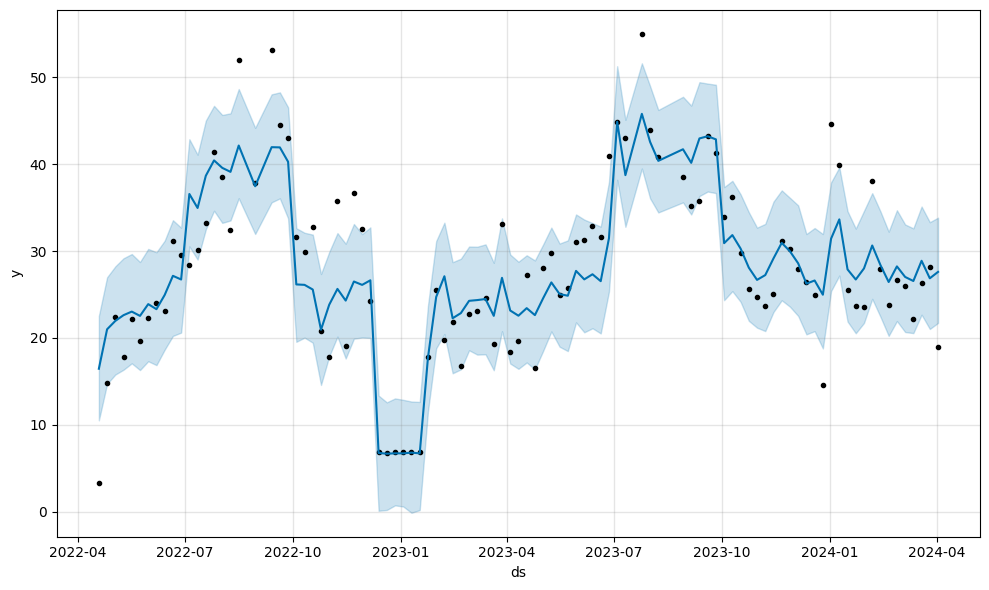

In [19]:
pd.options.display.float_format = '{:.2f}'.format
m = Prophet(daily_seasonality=False,
            weekly_seasonality=False,
            interval_width=0.80,
            changepoint_prior_scale=0.01,
            seasonality_prior_scale=0.01,
            holidays_prior_scale=10,
            holidays=holidays)

m.add_country_holidays(country_name='US')
m.add_seasonality(name='yearly', period=365.25, fourier_order=15)
m.add_seasonality(name='monthly', period=30.5, fourier_order=15)
m.add_regressor('summer')

m.fit(filtered_df)
forecast = m.predict(filtered_df)
fig1 = m.plot(forecast)

In [20]:
#Train
forecast['ds'] = pd.to_datetime(forecast['ds'])
weekly_df['ds'] = pd.to_datetime(weekly_df['ds'])

forecast_frame = forecast[['ds','yhat','yhat_lower','yhat_upper']].merge(weekly_df[['ds','y']],on='ds',how='left')

forecast_final_train_clean = forecast_frame.dropna(subset=['y','yhat'])

y_true = forecast_final_train_clean["y"]
y_pred = forecast_final_train_clean["yhat"]

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print("MAE:", mae)

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)
print("MSE:", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Calculate R^2
r2 = r2_score(y_true, y_pred)
print("R^2:", r2)

MAE: 3.637349190788639
MSE: 23.592169476703145
RMSE: 4.857177109875977
R^2: 0.7858777584482094


Future DataFrame & Forecast

In [21]:
# Make future DataFrame
future_weekly = m.make_future_dataframe(periods=52, freq='W-MON')
future_weekly['summer'] = future_weekly['ds'].apply(lambda x: 1 if x.month in [7, 8, 9] else 0)

In [22]:
forecast_weekly = m.predict(future_weekly)

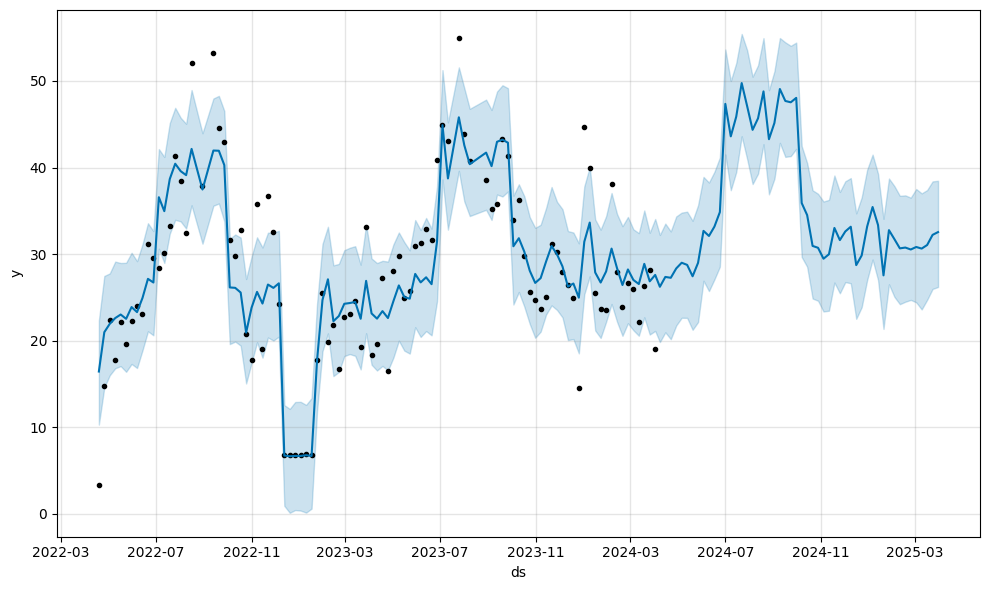

In [23]:
fig2 = m.plot(forecast_weekly)

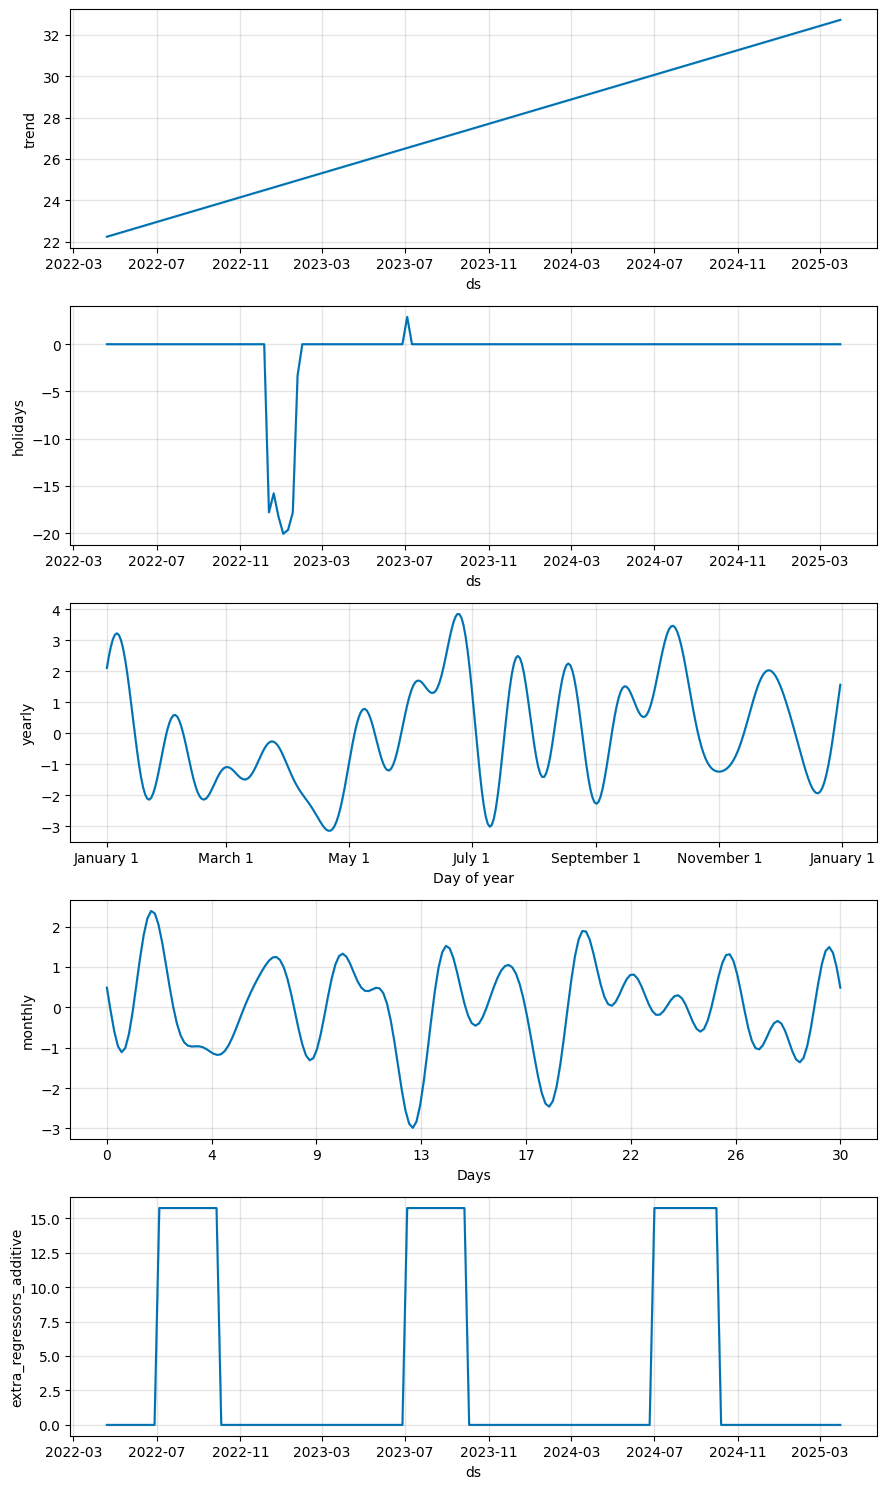

In [24]:
fig3 = m.plot_components(forecast_weekly)

Cross Validation

In [25]:
df_cv = cross_validation(m, initial='365.25 days', period='30 days', horizon = '60 days')

INFO:prophet:Making 10 forecasts with cutoffs between 2023-05-08 00:00:00 and 2024-02-02 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpme9a1r_k/2jjms8oh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme9a1r_k/wuqu7ibw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67481', 'data', 'file=/tmp/tmpme9a1r_k/2jjms8oh.json', 'init=/tmp/tmpme9a1r_k/wuqu7ibw.json', 'output', 'file=/tmp/tmpme9a1r_k/prophet_model17pxdanb/prophet_model-20240413210856.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:08:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:08:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme9a1r_k/yu4cdeqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme9a1r_k/webk8nhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [26]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(20)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,34.50,5.87,5.32,0.16,0.16,0.16,0.50
1,7 days,52.22,7.23,6.53,0.19,0.19,0.19,0.38
2,8 days,43.36,6.58,5.27,0.15,0.13,0.15,0.62
3,10 days,46.01,6.78,5.59,0.17,0.13,0.16,0.56
4,11 days,40.66,6.38,5.03,0.16,0.13,0.15,0.62
5,12 days,40.85,6.39,5.06,0.16,0.14,0.15,0.62
6,13 days,34.95,5.91,4.58,0.15,0.14,0.14,0.75
7,14 days,18.92,4.35,3.62,0.13,0.11,0.12,0.88
8,15 days,22.37,4.73,4.13,0.15,0.14,0.14,0.88
9,17 days,15.18,3.90,3.47,0.12,0.11,0.11,1.00


HyperParameter Tuning

In [31]:
import itertools
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each set of parameters here

# Use cross-validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params,
                daily_seasonality=False,
                interval_width=0.8,
                holidays=holidays) \
    .add_country_holidays(country_name='US') \
    .add_seasonality(name='yearly', period=365.25, fourier_order=15)\
    .add_seasonality(name='monthly', period=30.5, fourier_order=15)\
    .add_regressor('summer')\
    .fit(filtered_df)

    # Perform cross-validation
    df_cv = cross_validation(m, initial='365.25 days', horizon='91 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)

    # Append the RMSE to the list of RMSEs
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters based on RMSE
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

# Print the best parameters
best_parameters = tuning_results.loc[tuning_results['rmse'].idxmin()]
print(best_parameters)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2uekcdx/8jgyq2lx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2uekcdx/xp4igj2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35826', 'data', 'file=/tmp/tmpm2uekcdx/8jgyq2lx.json', 'init=/tmp/tmpm2uekcdx/xp4igj2_.json', 'output', 'file=/tmp/tmpm2uekcdx/prophet_model_r5ynkxg/prophet_model-20240413204450.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:44:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cutoffs

KeyboardInterrupt: 

In [33]:
future_weekly = m.make_future_dataframe(periods=52, freq='W-MON')
future_weekly['summer'] = future_weekly['ds'].apply(lambda x: 1 if x.month in [7, 8, 9] else 0)

forecast = m.predict(future_weekly)

forecast['ds'] = pd.to_datetime(forecast['ds'])
weekly_df['ds'] = pd.to_datetime(weekly_df['ds'])

forecast_final = forecast[['ds','yhat','yhat_lower','yhat_upper']].merge(weekly_df[['ds','y']],on='ds',how='left')

In [34]:
forecast_final.tail()

,ds,yhat,yhat_lower,yhat_upper,y
145,2025-03-03,30.82,24.56,37.07,NaN
146,2025-03-10,30.64,24.44,37.07,NaN
147,2025-03-17,31.05,25.03,37.52,NaN
148,2025-03-24,32.22,26.13,38.01,NaN
149,2025-03-31,32.54,26.52,39.10,NaN


In [37]:
import plotly.express as px

# Assuming forecast_final is a DataFrame with columns 'ds', 'y', and 'yhat'
fig = px.line(forecast_final, x='ds', y='y', title='PG&E Usage Forecast vs Actual')
fig.add_scatter(x=forecast_final['ds'], y=forecast_final['yhat'], mode='lines', name='Forecast', line=dict(color='red'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Cost',
    legend_title='Legend'
)

fig.show()
